In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

(584, 565, 3)

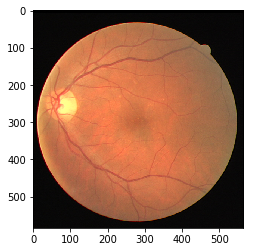

In [2]:
img = cv2.imread('data/DRIVE/training/images/21_training.tif')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
img.shape

(584, 565, 3)

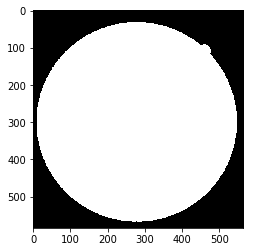

In [3]:
mask = plt.imread('data/DRIVE/training/mask/21_training_mask.gif') #cause cv2 can't read gifs :X
plt.imshow(mask, cmap='gray')
img.shape

(584, 565)

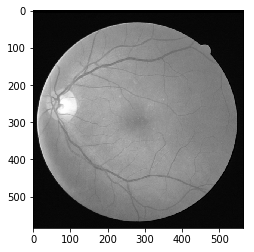

In [4]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
gray.shape

251

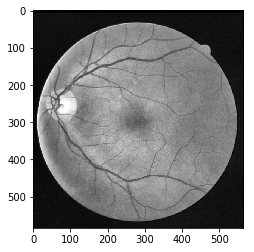

In [5]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" 
#(tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. 
#So in a small area, histogram would confine to a small region (unless there is noise). 
#If noise is there, it will be amplified. To avoid this, contrast limiting is applied. 
#If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), 
#those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 
#After equalization, to remove artifacts in tile borders, bilinear interpolation is applied

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hist_eq = clahe.apply(np.array(gray, dtype = np.uint8))
plt.imshow(hist_eq, cmap='gray')
hist_eq.max()

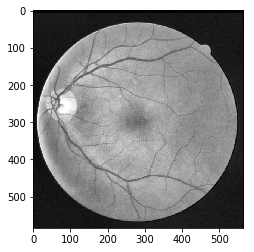

In [6]:
gamma = 1.2
# build a lookup table mapping the pixel values [0, 255] to
# their adjusted gamma values
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
# apply gamma correction using the lookup table
gamma_corrected = cv2.LUT(hist_eq, table)
plt.imshow(gamma_corrected, cmap='gray')

In [7]:
#gamma_corrected = gamma_corrected / 255.
#edges = cv2.Canny(gamma_corrected, 100, 200)
#plt.imshow(edges, cmap='gray')

#edges = filters.sobel(gamma_corrected)
#plt.imshow(edges, cmap='gray')

#edges = feature.canny(gamma_corrected)
#plt.imshow(edges, cmap='gray')

#all above not satisfactory. Why? We should use RIDGE detection instead of EDGE detection.

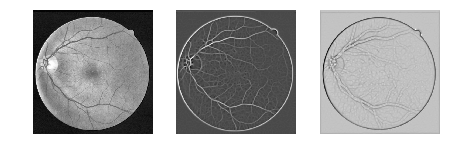

In [8]:
def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

a, b = detect_ridges(gamma_corrected, sigma=3.0)

plot_images(gamma_corrected, a, b)

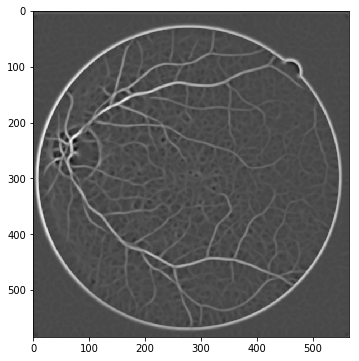

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(a,cmap='gray')

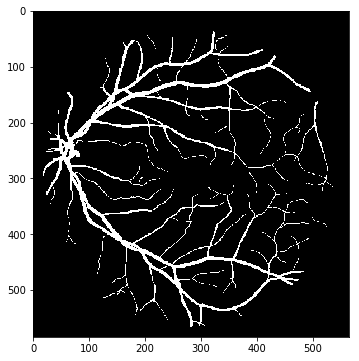

In [10]:
labeled = plt.imread('data/DRIVE/training/1st_manual/21_manual1.gif')
plt.figure(figsize=(6,6))
plt.imshow(labeled, cmap='gray')

In [11]:
a = a + (a.min() * (-1)) #just some normalization stuff, because we were going negative
a = a/a.max()
a = a*255
a = a.astype('uint8') # basic conversion for cv2 operations to work properly

In [12]:
#median = cv2.medianBlur(a, 5) #not so much of an effect here :X
#plt.imshow(median, cmap='gray')

In [13]:
#kernel = np.ones((6,6),np.uint8) #erosion and dilation also not so effective
#erosion = cv2.erode(a,kernel,iterations = 5)
#dilation = cv2.dilate(a,kernel, iterations =1 )
#plt.figure(figsize=(6,6))
#plt.imshow(dilation, cmap='gray')

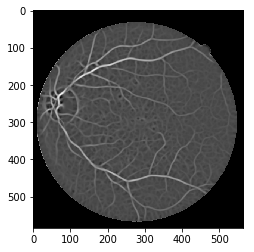

In [14]:
masked = np.zeros(a.shape)
masked[mask > 0] = a[mask > 0]
plt.imshow(masked, cmap='gray')

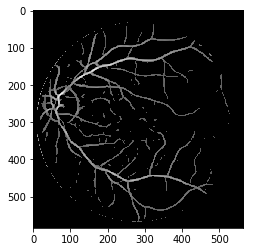

In [41]:
def cover_ratio(transformed, label): #what part of white pixels were actually covered
    return np.sum(transformed * label)/np.sum(label)

def accuracy(transformed, label):
    return (transformed == label).sum()/(label.shape[1]*label.shape[0])

thresh = masked.copy()
thresh[thresh < 90] = 0
thresh = thresh/thresh.max()
plt.imshow(thresh, cmap='gray')

#accuracy(thresh, labeled)
#cover_ratio(thresh, labeled)
#accuracy(np.zeros(labeled.shape), labeled)